# 4. Firma ubezpieczeniowa.

In [115]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython import display

Zaczynamy prowadzić naszą firmę z:

*   początkowym kapitałem równym $k_0$,
*   początkową liczbą sprzedanych polis OC równą $n$,
*   początkową liczbą sprzedanych polis AC równą $m$.



## Funkcje, generatory i stałe potrzebne do wygenerownia procesu ryzyka.

### Rezygnacje z OC.

#### Generator zmiennych losowych $N$ z rozkładu dyskretnego. <br>
Wykorzystujemy do generowania pierwszego parametru w rozkładzie dwumianowym.

In [1]:
def N_distr_gen(n):
    """Generate random variable from discreet distribution.

    Args:
        n [int]: actual count of OC clients.

    Returns:
        [int]: random variable.
    """
    u = np.random.uniform(0, 1)
    if u <= 0.5:
        return n
    elif 0.5 < u <= 0.8:
        return np.floor(0.9*n)
    else:
        return np.floor(n/2)

#### Generowanie liczby kierowców rezygnujących z OC na początku miesiąca.
Wartość popytu na polisy OC ($m_{OC}$) powinna być mniejsza lub równa wartości ceny polisy ($c_{OC}$), żeby drugi parametr rozkładu dwumianowego (parametr $p$ - prawdopodobieństwo) był mniejszy lub równy 1. W przeciwnym wypadku rozkład nie będzie działał (ponieważ prawdopodobieństwo nie może przekraczać 1).<br>
Jeżeli jednak parametr $p$ przekroczy wartość 1, wtedy za $p$ podstawiamy 0.9
(w celu uniknięcia błędów).

In [2]:
def count_quit_OC_gen(n, c_OC, m_OC):
      """Generate count of clients resign OC.

      Args:
          n [int]: actual count of OC clients,
          c_OC [int, float]: OC policy price,
          m_OC [int, float]: demand for OC policy.

      Returns:
          [int]: count of clients resign OC.
      """
      if n == 0:
        return 0
      p = (c_OC/m_OC)**2.5
      if p > 1:
          p = 0.9
      return np.random.binomial(N_distr_gen(n), p)

### Rezygnacja z AC.

#### Generowanie liczby kierowców rezygnujących z AC na początku miesiąca.
Zmienna $Z$ zwraca liczby z rozkładu $N(0, 1)$ (z dużym prawdopodobieństwem są to wartości z przedziału od -3 do 3), dlatego też zmienna $|Z|$ ma wartości z przedziału od 0 do 3.
Żeby parametr $p = |Z|\frac{c_{AC}}{m_{AC}}$ w rozkładzie dwumianowym był mniejszy lub równy 1, wartość $m_{AC}$ musi być co najmniej 3 razy większa niż wartość $c_{AC}$ (inaczej rozkład nie będzie działał).<br>
Jeżeli jednak parametr $p$ przekroczy wartość 1, wtedy (analogicznie do przypadku generowania liczby rezygnacji z OC) za $p$ podstawiamy 0.9.

In [3]:
def count_quit_AC_gen(m, c_AC, m_AC):
    """Generate count of clients resign AC.

    Args:
        m [int]: actual count of AC clients,
        c_AC [int, float]: price of AC policy,
        m_AC [int, float]: demand for AC policy.

    Returns:
        [int]: count of clients resign AC.
    """
    Z = np.random.normal(0, 1)
    p = np.abs(Z)*(c_AC/m_AC)
    if p > 1:
        p = 0.9
    return np.random.binomial(m, p)

### Wnioski:
Wraz ze zwiększaniem się popytu na polisy, prawdopodobieństwo rezygnacji z ubezpieczeń zmniejsza się, a co za tym idzie mniej klientów odchodzi z naszej firmy.<br>
Im większe ceny polis, tym więcej klientów rezygnuje z kupowania polis w naszej firmie.

### Generowanie liczby nowo sprzedanych polis OC na początku każdego miesiąca.

Nakłady na marketing ($\mu$) zwracają nam się w postaci nowych klientów.<br>
Żeby marketing był dla nas opłacalny, generując parametr $\lambda = 2\log(1 + 1000\mu\sqrt{\frac{M}{c_{OC}} + \frac{s_{OC}}{c_{OC}}})$ w rozkładzie Poissona mnożymy $\mu$ razy 1000.<br>
W reklamę inwestujemy stałą kwotę równą 1000 zł - jest to dla nas najbardziej opłacalne - przy większych nakładach liczba naszych klientów i tak nie będzie znacząco rosnąć.<br>
Parametr $s_{OC}$ (stała związana z popytem) ma u nas niezmienną wartość równą 100. Również parametr $n_0$ jest stały i wynosi 100.<br>
Aktualna liczba klientów (w tym także parametr $n_0$) nie ma dużego wpływu na ilość nowo sprzedanych polis.

#### Generator zmiennych losowych $M$ z rozkładu dyskretnego.
Wykorzystujemy przy generowaniu liczby nowych klientów na początku miesiąca.

In [4]:
def M_distr_gen(n, n_0):
    """Generate random variable from discreet distribution.

    Args:
        n [int]: actual count of OC clients,
        n_0 [int, float]: fixed parameter.

    Returns:
        [int]: random variable.
    """
    u = np.random.uniform(0, 1)
    if u <= 0.1:
        return n/2
    elif 0.1 < u <= 0.2:
        return n/3
    elif 0.2 < u <= 0.6:
        return n/5
    else:
        return n_0

#### Generator liczby nowo sprzedanych polis OC.

In [5]:
def count_sale_OC_gen(n, n0, s_OC, c_OC, mu):
    """Generate count of sale OC policy.

    Args:
        n [int]: actual count of OC clients,
        n_0 [int, float]: fixed parameter,
        s_OC [int, float]: constant related to the demand,
        c_OC [int, float]: OC policy price,
        mu [int, float]: marketing price.

    Returns:
        [int]: count of sale OC.
    """
    M = M_distr_gen(n, n0)
    advert = 1000*mu
    lamb = 2*np.log(1 + advert*np.sqrt(M/c_OC) + s_OC/c_OC)
    return np.random.poisson(lamb)

### Generowanie liczby nowo sprzedanych polis AC na początku każdego miesiąca.

Aktualna liczba naszych klientów OC ma bardzo duży wpływ na to, ile nowych polis AC sprzedamy. Liczba nowych klientów AC jest odwrotnie proporcjonalna do iloczynu ilości klientów OC oraz ceny polisy AC. Co oznacza, że im więcej klientów OC kupuje polisy w naszej firmie, tym mniej klientów AC zacznie do nas przychodzić.<br>
Ponadto gdy nie mamy żadnych klientów AC na początku, klienci ci nie zaczną się pojawiać.<br>
W celu uniknięcia błędnego działania programu, gdy parametr $p$ w rozkładzie dwumianowym przekroczy wartość 1, wtedy za $p$ podstawiamy 0.9.

In [6]:
def count_sale_AC_gen(n, m, c_AC):
    """Generate count of sale AC policy.

    Args:
        n [int]: actual count of OC clients,
        m [int]: actual count of AC clients,
        c_AC [int, float]: AC policy price.

    Returns:
        [int]: count of sale AC.
    """
    p = m/(n*c_AC)
    if p > 1:
        p = 0.9
    return np.random.binomial(n, p)

### Funkcja licząca łączny miesięczny przychód ze sprzedaży polis OC i AC.

In [7]:
def monthly_income(n, c_OC, m, c_AC):
    """Count monthly income from sale.

    Args:
        n [int]: actual count of OC clients,
        c_OC [int, float]: OC policy price,
        m [int]: actual count of AC clients,
        c_AC [int, float]: AC policy price.

    Returns:
        [int, float]: income value.
    """
    return n*c_OC + m*c_AC

### Odszkodowania OC.

#### Generator czasu pojawiania się szkód dla wszystkich klientów, którzy kupili OC.

Generator zwraca czasy szkód w ciągu jednego miesiąca.<br>
Funkcja intensywności ($\lambda (t)$) zależy od konkretnego okresu w roku oraz ilości sprzedanych polis OC i jest opisana wzorem:
$$\lambda(t) = \sum_{i=0}^{n(t)}W_i\cdot \lambda_0(t),$$
gdzie:<br><br>
$n(t)$ - ilość sprzedanych w danym miesiącu polis (wliczamy stałych i nowych klientów),<br>
$W_i \sim Exp(\lambda_{wi})$ - zmienna opisująca jak często dany kierowca miewa stłuczki,<br>
$\lambda_0(t)$ - intensywność wypadków w zależności od okresu w roku.

##### Dobieranie parametru intensywności $\lambda_0$ w zależności od danego miesiąca.

Procentowy rozkład wypadków dla danego miesiąca w roku 2020:<br>
<center>
<img src="wypadki_drogowe_tabelka.png" alt="Wypadki drogowe w 2020"/>
</center>

Na podstawie danych z tabelki dobierzemy intesywność $\lambda _0$.<br>
W naszym przypadku średnia intensywność wypadków (wartość referencyjna) wynosi 1, dlatego procentowe dane z tabelki skalujemy według tej średniej. Średnia z tabelki wynosi około $8.3\%$. Przykładowo przeskalowana intensywość dla stycznia wynosi $\frac{8.5\%}{8.3\%} \approx 1.03$.

In [8]:
def lamb0(month):
    """Return intensity depend on month in year.

    Args:
        month [int]: number from 1 to 12.

    Returns:
        [float]: intensity.
    """
    intensity= [1.03, 0.94, 0.73, 0.59, 0.87, 1.17, 1.29, 1.33, 1.31, 1.08, 0.8, 0.94]
    i = int(month%12)
    return intensity[i-1]

In [9]:
def lamb(count_of_sale, lamb_wi, month):
    """Generate Poisson intensity function depend on month.
    Args:
        count_of_sale [int]: count of sale OC policy,
        lamb_wi [int, float]: parametr in exponential distribution,
        month [int]: number from 1 to 12.

    Returns:
        [float]: intensity.
    """
    return sum([np.random.exponential(1/lamb_wi)*lamb0(month) for __ in range(count_of_sale)])

In [10]:
def accident_OC_time_gen(count_of_sale, lamb_wi, month, T=30):
    """Generate accidents times for clients with OC policy.

    Args:
        count_of_sale [int]: count of sale OC policy,
        lamb_wi [int, float]: parametr in exponential distribution,
        month [int]: number from 1 to 12,
        T (int, optional): time range in days. Defaults to 30.

    Returns:
        [list]: list with accidents times.
    """
    S = []
    t = 0
    mybool = True
    l = lamb(count_of_sale, lamb_wi, month)
    if l > 0:
        while mybool:
            U = np.random.uniform(0, 1)
            t = t - (1/l)*np.log(U)
            if t > T:
                mybool = False
            else:
                S.append(t)
    else:
        S = []
    return S

#### Generator wielkości pojedynczego odszkodowania dla klienta z polisą OC.

Dobieranie parametru Pareto:<br>
Zmienną z rozkładu Pareto generujemy z parametrem 0.7. Jeżeli zmienna ta przekroczy wartość $40000$ [zł] (bo do takiej kwoty nasza firma wypłaca odszkodowania), wtedy wypłacamy 40000 zł.<br>
Za każdym razem do zmiennej z rozkładu Pareto dodajemy 500 zł, żeby ceny odszkodowań miały sensowne wartości (zbliżone do tych w rzeczywistym życiu).

In [11]:
def size_of_OC_compensation():
    """Generate modified random value from Pareto distribution.

    Returns:
        [float]: random value.
    """
    pareto = np.random.pareto(0.7) + 500
    if pareto > 40000:
        pareto = 40000
    return pareto

#### Łączna miesięczna wartość odszkodowań OC dla wszystkich klientów.

In [12]:
def monthly_OC_compensation_value(n, lamb_wi, month):
    """Count monthly OC compensation value for all clients.

    Args:
        n [int]: count of sale OC policy,
        lamb_wi [int, float]: parametr in exponential distribution,
        month [int]: number from 1 to 12.

    Returns:
        [float]: value of OC compensations.
    """
    accidents_amount = len(accident_OC_time_gen(n, lamb_wi, month, T=30))
    payment  = sum([size_of_OC_compensation() for __ in range(accidents_amount)])
    return payment

### Odszkodowania AC.

#### Generator czasu pojawiania się szkód dla pojedynczego klienta, który kupił polisę AC.

In [13]:
def accident_AC_time_gen(T=30):
    """Generate accidents times for clients with AC policy.

    Args:
        T (int, optional): time range in days. Defaults to 30.

    Returns:
        [list]: list eith accidents times.
    """
    S = []
    t = 0
    mybool = True
    while mybool:
        V = np.random.rayleigh(100*np.sqrt(np.pi/2))
        tv = t + 20
        u = np.random.uniform(tv, tv+V)
        t = t + u
        if t > T:
            mybool = False
        else:
            S.append(t)
    return S

Czas oczekiwania na sygnał jest zmienną z rozkładu $U(t_v, t_v + V)$.<br> W naszym przypadku $t_v = t + 20$ jest zmienną zależną od czasu poprzedniego skoku. Ponieważ generator zwraca czasy wypadków dla jednego klienta w ciągu miesiąca, nie powinno być ich dużo, a najczęściej nie będzie ich wcale. 

#### Wielkości odszkodowań dla klientów z polisami AC.


Ponieważ zmienne z rozkładu Cauchy'ego zwracają zazwyczaj bardzo małe wartości, dlatego mnożymy je razy 10 i dodajemy do nich 500 (wtedy kwoty odszkodowań mają wartości bardziej zbliżone do rzeczywistych).<br>
Kwota wypłacanego odszkodowania nie może przekroczyć wielokrotności (stała $M_{AC}$) ceny polisy ($c_{AC}$).
W naszym przypadku jest to $10\cdot c_{AC}$ ($M_{AC} = 10$).

In [14]:
def size_of_AC_compensation(M_AC, c_AC):
    """Generate compensation value.

    Args:
        M_AC [int]: multiple of AC policy price,
        c_AC [int, float]: AC price.

    Returns:
        [flaot]: AC compensation value.
    """
    c = np.random.standard_cauchy()*10 + 500
    return min(np.abs(c)/2, M_AC*c_AC)

#### Łączna miesięczna wartość odszkodowań AC dla wszystkich klientów.

In [15]:
def monthly_AC_compensation_value(m, M_AC, c_AC):
    """Count monthly AC compensation value for all clients.

    Args:
        m [int]: count of sale AC policy,
        M_AC [int]: multiple of AC policy price,
        c_AC [int, float]: AC price.

    Returns:
        [float]: value of AC compensations.
    """
    accidents_amount = sum([len(accident_AC_time_gen()) for __ in range(m)])
    return sum([size_of_AC_compensation(M_AC, c_AC) for __ in range(accidents_amount)])

### Funkcja licząca wartość przy której automatycznie bankrutujemy.


Jest ona zdefiniowana wzorem:
$$bankructwo = -2k_0 - nc_{AC},$$
gdzie:<br>
$k_0$ - kapitał początkowy,<br>
$n$ - ilość aktualnych klientów, którzy kupili OC w naszej firmie,<br>
$c_{AC}$ - cena polisy AC.

In [16]:
def bankruptcy_value(n, k0, c_AC):
    """Count bankruptcy value.

    Args:
        n [int]: actual count of OC clients,
        k0 [int, flaot]: start-up capital,
        c_AC [int, float]: AC price.

    Returns:
        [flaot]: bankruptcy value.
    """
    return -2*k0 - n*c_AC

### Wartość podatku, który płacimy raz w roku.

Funkcję liczącą wartość podatku definiujemy następująco:
$$podatek = 0.3\cdot z + 0.05\cdot p + 0.04 \cdot k,$$
gdzie:<br>
$k$ - kapitał - aktualny kapitał naszej firmy,<br>
$p$ - przychód - łączna wartość sprzedanych polis OC i AC w ciągu roku,<br>
$z$ - zysk - różnica przychodu i kosztów ich uzyskania (gdzie do kosztów wliczamy: nakłady na marketing ($\mu$), wypłacane odszkodownia OC i AC oraz jeśli zaciągnęliśmy kredyt doliczmy oprocentownie w wysokości $r$).<br>
Odsetki z całegu kredytu wynoszą: $20 \cdot \frac{1}{12} kredytu - kredyt = \frac{2}{3} kredytu$, co miesiąc do kosztów uzyskania przychodu doliczamy $\frac{1}{20}$ tych odetek:
$$r = \frac{1}{20}\cdot\frac{2}{3} kredytu = \frac{1}{30} kredytu.$$

In [17]:
def pay_tax(year_income, year_loss, capital):
    """Count value of tax.

    Args:
        year_income [int, float]: income in year,
        year_loss [int, float]: cost of getting income,
        capital [int, float]: actual capital.

    Returns:
        [flaot]: value of tax to pay.
    """
    profit = year_income - year_loss
    profit_tax  = 0
    capital_tax = 0
    income_tax = 0.05*year_income
    if profit > 0:
        profit_tax = 0.3*profit
    if capital > 0:
        capital_tax = 0.04*capital
    return  profit_tax + income_tax + capital_tax

### Funkcja generująca wysokość kredytu.

In [18]:
def credit_gen(R):
    """Count credit value.

    Args:
        R [int, float]: actual capital.

    Returns:
        [int, float]: credit value
    """
    return abs(R) + 10000

### Parametry wykorzystywane w rozkładach.
Parametry są stałe,  niezależnie od strategii i zostały dobrane tak, aby symulacja zwracała jak najbardziej rzeczywiste wyniki.

In [19]:
n0 = 100
#stała związana z popytem 
s_OC = 100
#stała do rozkładu wykładniczego
lamb_wi = 500
#wielokrotność ceny polisy
M_AC = 10

#### Popyt na polisy.
Żeby rozkład dwumianowy działał jak najbardziej losowo, to w przypadku popytu na polisy OC, jego wartość powinna być większa lub równa cenie polisy.<br>
Popyt na polisy AC powinien być około 3 razy większy niż cena tej polisy.<br>
Dlatego też zakładając że popyt jest stały:<br>
$m_{OC} = 200$, ceny polis OC nie powinny przekraczać 200,<br>
$m_{AC} = 240$, ceny polis AC nie powinny przekraczać 80.

In [143]:
m_AC = 240
m_OC = 200

## Symulacja procesu ryzyka

### ALGORYTM:
Początek i koniec symulacji podajemy jako numer miesiąca. Lata podajemy przeliczone na miesiące.

Dla każdego miesiąca z podanego przedziału czasu:

1. Sprawdzamy czy zbankrutowaliśmy, jeśli nie, wykonujemy nastepujące kroki:

  1.1. Sprawdzamy czy spłacamy kredyt, jeżeli tak, to
obliczamy ratę kredytu i doliczamy oprocentowanie do kosztów uzyskania przychodu.

  1.2. Na podstwie strategii na marketing, sprawdzamy czy inwestujemy w reklamę w danym miesiącu.

  1.3. Obliczamy aktualną liczbę klientów (dodaje nowych i odejmujemy, tych którzy zrezygnowali) oraz sprawdzamy czy ich liczba nie jest ujemna (jeżeli tak jest, to podstawiamy 0 za liczbę klientów).

  1.4. Rejestrujemy miesięczny oraz roczny przychód.

  1.5. Zapisujemy kapitał (dla danego miesiąca) powiększony o przychody.
Jeżeli kapitał w tym momencie jest dodatni, kończymy odliczanie czasu ruiny (licznik zerujemy).

  1.6. Obliczamy wielkości odszkodowań, które płacimy w danym miesiącu.

  1.7. Obliczamy aktualny kapitał, od którego będziemy płacić podatek.

  1.8. Jeżeli jest kwiecień płacimy podatek i odejmujemy go od kapitału.
  
  1.9. Zapisujemy aktualny kapitał.

  1.10. Sprawdzamy czy kapitał jest ujemny, jeżeli jest, to zwiększamy czas ruiny i jeżeli nie mamy żadnych zobowiązań, bierzemy kredyt.

  1.11. Sprawdzamy, czy zarabiamy milion.

  1.12. Jeżeli nasz kapitał osiąga $10^6$ (i $\textit{million_check=True}$) lub skończył się czas symulacjizwracamy tablice czasu i kapitału.
2. W przypadku bankructwa zatrzymujemy proces ryzyka i zwracamy tablice wartości do momentu bankructwa.

In [21]:
def risk_process(start, stop, k0, n, m, c_AC, c_OC, m_OC=200, m_AC=240, s_OC=100, lamb_wi=500, M_AC=10, million_check=False):
    """Generate risk process.

    Args:
        start [int]: month when simulation starts,
        stop [int]: month when simulation stops,
        k0 [float, int]: start-up capital,
        n [int]: initial number of OC clients,
        m [int]: initial number of AC clients,
        c_AC [float, int]: AC price,
        c_OC [float, int]: OC, price,
        m_OC (int, optional): demand for OC policy. Defaults to 200.
        m_AC (int, optional): demand for AC policy. Defaults to 240.
        s_OC (int, optional): demand parameter. Defaults to 100.
        lamb_wi (int, optional): exponential distribution parameter. Defaults to 500.
        M_AC (int, optional): multiply of AC price parameter. Defaults to 10.
        million_check (bool, optional): boolean to check if capital has reached a million. Defaults to False.

    Returns:
        [tuple with 2 lists]: list with time data, list with capital data.
    """
    R_range = [k0]
    time_range = [0]
    bankruptcy = bankruptcy_value(n, k0, c_AC)
    k = 0
    t = 0
    R = k0
    n_var = n
    m_var = m
    credit_time = False
    credit_start_counter = 26
    credit_rate = 0
    ruin_counter = 0
    tax = 0
    year_income = 0
    year_loss = 0
    mu = 1000
    millionaire = 0
    for t in range(start, stop+1):
        if R > bankruptcy and ruin_counter < 24:
            if credit_time:
                #jeżeli zaciągnęliśmy kredyt zaczynamy odliczanie pół roku
                credit_start_counter -= 1
            #po upływie pół roku zaczynamy spłacać kredyt
            #sprawdzamy czy już spłaciliśmy kredyt
            if 0 < credit_start_counter <= 20:  
                credit_rate = (1/12)*credit
                credit_start_counter -= 1
                #jeżeli spłacamy kredyt, to do kosztów uzysaknia przychodu doliczmy oprocentowanie kredytu
                year_loss += (1/30)*credit
            #po spłaceniu kredytu liczniki zerujemy 
            elif credit_start_counter <= 0 :
                credit_time = False
                credit_start_counter = 26
                credit_rate = 0

            #sprawdzamy czy inwestujemy w marketing
            if mu > 5*R:
                mu = 0
            else:
                mu = 100
            
            clients_quiting_OC = count_quit_OC_gen(n_var, c_OC, m_OC) #ilość klientów rezygnująca z OC
            clients_quiting_AC = count_quit_AC_gen(m_var, c_AC, m_AC) #ilość klientów rezygnująca z AC
            sale_OC = count_sale_OC_gen(n_var, n0, s_OC, c_OC, mu)
            sale_AC = count_sale_AC_gen(n_var, m_var, c_AC)
            n_var = n_var + sale_OC - clients_quiting_OC
            m_var = m_var + sale_AC - clients_quiting_AC

            #sprawdzamy czy liczba klientów nie jest mniejsza od 0 (liczba klientów nie może być ujemna)
            if n_var < 0:
                n_var = 0
            if m_var < 0:
                m_var = 0

            income = monthly_income(n_var, c_OC, m_var, c_AC)
            #rejestrujemy roczne przychody
            year_income += income
            #zapisujemy kapitał powiększony o przychody
            R_plus = R + income
            R_range.append(R_plus)
            time_range.append(t)
            #sprawdzamy czy jesteśmy na plusie
            if R_plus > 0:
                ruin_counter = 0

            #obliczymy wielkość odszkodować dla wszystkich aktualnych klientów
            OC_compensation = monthly_OC_compensation_value(n_var, lamb_wi, t)
            AC_compensation = monthly_AC_compensation_value(m_var, M_AC, c_AC)
            
            year_loss += OC_compensation + AC_compensation + mu

            #na koniec kwietnia płacimy podatek (R to nasz aktualny kapitał)
            R = R + income - OC_compensation - AC_compensation - credit_rate - mu
            if t%12 == 4:
                tax = pay_tax(year_income, year_loss, R)
                #po zapłaceniu podatku zerujemy licznik
                year_income = 0
                year_loss = 0
            else:
                tax = 0         
            
            #zapisujemy kapitał pomniejszony o odszkodowania, podatek, ratę kredytu, marketing
            R = R - tax
            R_range.append(R)
            time_range.append(t)
            #na koniec miesiąca sprawdzamy, czy kapitał jest ujemny
            if R <= 0:
                ruin_counter += 1
            #sprawdzamy czy bierzemy kredyt
            if R <= 0 and credit_time == False:
                credit = credit_gen(R)
                R += credit
                credit_time = True
            bankrupty = bankruptcy_value(n_var, k0, c_AC)
            if million_check and R >= 10**6:
                millionaire += 1
                return time_range, R_range, millionaire     
        else:
          #po bankructwie zwracamy od razu tablice
          return time_range, R_range, millionaire
    return time_range, R_range, millionaire

## Analizy przeprowadzone w celu ustalenia strategii i tego jak nasza firma będzie rozwijać się na przestrzeni czasu.

### Strategia na marketing, zaciąganie kredytu, wysokości cen OC i AC.

#### MARKETING.
Jak już wcześniej ustatlilismy nie opłaca nam się inwestować w marketing więcej niż 1000 zł. Strategia polega na tym, że jeżeli nasz kapitał jest 5 razy większy  niż nakład na marketing (wynosi więcej niż 5000 zł), wtedy inwestujemy w marketing, w przeciwnym wypadku rezygnujemy z niego w danym miesiącu, żeby nie ryzykować utraty pieniędzy.<br>


#### KREDYT.
Jeżeli nasz kapitał spadnie poniżej 0, wtedy zaciągamy kredyt.
Wysokość kredytu wynosi: $|R| + 10000$, gdzie $R$ to aktualny kapitał. Wartość ta jest dobrana w taki sposób, żebyśmy po wzięciu kredytu mieli 10000 zł kapitału i mogli ustabilizować nasze dochody.<br>
Kredyt zaciągamy na koniec miesiąca, jeżeli mamy kwecień, to po zapłaceniu podatków (opłaca nam się to najbardziej, ponieważ przed zaciągnięciem kredytu mamy ujemny kapitał, z którego nie musimy płacić podatków).<br>

#### WYSOKOŚĆ CEN OC i AC.
Sprawdzamy symulacyjnie jakie ceny polis OC i AC będą najbardziej opłacalne dla naszej firmy.<br>
Jak wcześniej ustaliliśmy cena polis OC nie powinna przekroczyć 200 zł,
a cena AC 80 zł.<br>
Przeprowadzamy symulację dla następujących stałych parametrów:<br>
$k_0 = 1000$  zł - kapitał początkowy,<br>
$n = 10$ - początkowa ilość sprzedanych polis OC,<br>
$m = 0$ - początkowa ilość sprzedanych polis AC.<br>
Czas naszej symulacji wynosi 10 lat i wykonujemy ją dla kilku pakietów cen polis (zaczynamy od 40 zł w górę):<br>

  1.$c_{OC} = 40$ zł, $c_{AC} = 40$ zł,<br>

  2.$c_{OC} = 60$ zł, $c_{AC} = 50$ zł,<br>

  3.$c_{OC} = 80$ zł, $c_{AC} = 60$ zł,<br>

  4.$c_{OC} = 100$ zł, $c_{AC} = 70$ zł,<br>

  5.$c_{OC} = 120$ zł, $c_{AC} = 80$ zł.

In [36]:
k0 = 1000
n = 10
m = 0
start = 1
stop = 120

In [54]:
def price_simulation(start, stop, k0, n, m, c_OC, c_AC):
    """Count average final capital and probability of bankruptcy. Print results.

    Args:
        start [int]: month when simulation starts,
        stop [int]: month when simulation stops,
        k0 [float, int]: start-up capital,
        n [int]: initial number of OC clients,
        m [int]: initial number of AC clients,
        c_AC [float, int]: AC price,
        c_OC [float, int]: OC, price.
    """
    bankruptcy = 0
    capital_tab = []
    for __ in range(1000):
        #żeby sprawdzić czy nie zbankrutowaliśmy w ostatnim miesiącu wykonujemy symulację dla kolejnego miesiąca
        time, capital, millionaire  = risk_process(start, stop+1, k0, n, m, c_AC, c_OC)
        if time[-1] == stop+1:
            #zapisujemy ostatnią wartość kapitału dla ostatniego miesiąca w czasie symulacji
            capital_tab.append(capital[-3])
        else:
            bankruptcy += 1
    print("Średni kapitał końcowy przy cenie OC = {c_OC} [zł] i cenie AC = {c_AC} [zł]: ".format(c_OC=c_OC, c_AC=c_AC) + str(round(sum(capital_tab)/1000, 2))+" [zł], prawdopodobieństwo bankructwa: "+ str(bankruptcy/10)+"%.")

##### Pakiet 1

In [55]:
price_simulation(start, stop, k0, n, m, 40, 40)

Średni kapitał końcowy przy cenie OC = 40 [zł] i cenie AC = 40 [zł]: 99732.91 [zł], prawdopodobieństwo bankructwa: 38.8%.


##### Pakiet 2

In [56]:
price_simulation(start, stop, k0, n, m, 60, 50)

Średni kapitał końcowy przy cenie OC = 60 [zł] i cenie AC = 50 [zł]: 675281.66 [zł], prawdopodobieństwo bankructwa: 1.2%.


##### Pakiet 3 

In [57]:
price_simulation(start, stop, k0, n, m, 80, 60)

Średni kapitał końcowy przy cenie OC = 80 [zł] i cenie AC = 60 [zł]: 671319.14 [zł], prawdopodobieństwo bankructwa: 0.4%.


##### Pakiet 4

In [58]:
price_simulation(start, stop, k0, n, m, 100, 70)

Średni kapitał końcowy przy cenie OC = 100 [zł] i cenie AC = 70 [zł]: 572165.43 [zł], prawdopodobieństwo bankructwa: 0.1%.


##### Pakiet 5

In [59]:
price_simulation(start, stop, k0, n, m, 120, 80)

Średni kapitał końcowy przy cenie OC = 120 [zł] i cenie AC = 80 [zł]: 477113.89 [zł], prawdopodobieństwo bankructwa: 0.0%.


##### Wnioski:
Najmniejsze prawdopodobieństwo bankructwa zapewnia nam pakiet 5 ($c_{OC} = 120 $ zł i $c_{AC} = 80$ zł), największy średni kapitał uzyskujemy przy pakiecie 2 oraz przy pakiecie 3 ($c_{OC} = 60$ zł i $c_{AC} = 50$ zł oraz $c_{OC} = 80$ zł i $c_{AC} = 60$ zł). Jednak przy pakiecie 3 prawdopodobieństwo bankructwa jest mniejsze, niż 1%, dlatego też ten pakiet jest dla nas najbardziej optymalny.<br>
Na takiej podstawie ustalamy, że cena polisy OC będzie wynosić 80 zł, a cena polisy AC 60 zł.

##### Ustalone ceny polis.

In [37]:
c_OC = 80
c_AC = 60

### Analiza procesu ryzyka dla ustalonych wcześniej strategii.

#### Funkcja generująca wykres procesu ryzyka.

In [25]:
def draw_plot(start, stop, k0, n, m, c_AC, c_OC):
    """Generate plot.

    Args:
        start [int]: month when simulation starts,
        stop [int]: month when simulation stops,
        k0 [float, int]: start-up capital,
        n [int]: initial number of OC clients,
        m [int]: initial number of AC clients,
        c_AC [float, int]: AC price,
        c_OC [float, int]: OC price.
    """
    x_range, y_range, millionaire  = risk_process(start, stop, k0, n, m, c_AC, c_OC)
    plt.plot(x_range, y_range)
    plt.axhline(y=0, linestyle="--", color="red")
    plt.axhline(y=10**6, linestyle="--", color="m")
    plt.title("Proces ryzyka")
    plt.xlabel("miesiąc")
    plt.ylabel("kapitał")
    plt.show()

#### Symulacja procesu ryzyka po 10 latach funkcjonowania firmy.

In [41]:
def capital_simulation(start, stop, k0, n, m, c_OC, c_AC):
    """Count capital and bankruptcy value

    Args:
        start [int]: month when simulation starts,
        stop [int]: month when simulation stops,
        k0 [float, int]: start-up capital,
        n [int]: initial number of OC clients,
        m [int]: initial number of AC clients,
        c_AC [float, int]: AC price,
        c_OC [float, int]: OC price.

    Returns:
        [tuple with 4 float values]: maximum capital value, minimum capital value,
        average capital value, bankruptcy probability
    """
    bankruptcy = 0
    capital_tab = []
    for __ in range(1000):
        #żeby sprawdzić czy nie zbankrutowaliśmy w ostatnim miesiącu wykonujemy symulację dla kolejnego miesiąca
        time, capital, millionaire  = risk_process(start, stop+1, k0, n, m, c_AC, c_OC)
        if time[-1] == stop+1:
            #zapisujemy ostatnią wartość kapitału dla ostatniego miesiąca w czasie symulacji
            capital_tab.append(capital[-3])
        else:
            bankruptcy += 1
    return round(min(capital_tab), 2), round(max(capital_tab), 2), round(sum(capital_tab)/1000, 2), bankruptcy/10

In [43]:
min_capital, max_capital, average_capital, bankruptcy_prob = capital_simulation(1, 120, k0, n, m, 80, 60)

In [45]:
print("Minimalna wartość kapitału: "+ str(min_capital) + " zł, " + "maksymalna wartość kapitału: "+ str(max_capital) + " zł, " + "średnia wartość kapitału: "+ str(average_capital) + " zł.")
print("Prawdopodobieństwo bankructwa: "+str(bankruptcy_prob)+"%.")

Minimalna wartość kapitału: 546291.67 zł, maksymalna wartość kapitału: 796151.78 zł, średnia wartość kapitału: 672241.6 zł.
Prawdopodobieństwo bankructwa: 0.1%.


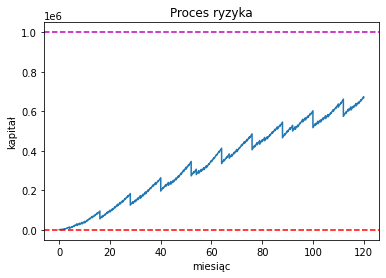

In [53]:
draw_plot(start, stop, k0, n, m, c_AC, c_OC)

##### Wnioski.
Symulacyjnie ustaliliśmy, że średnia wartość kapitału po 10 latach wynosi: 672241.6 zł.<br>
Widzimy jednak, że wartości te wahają się pomiędzy minimalną równą: 546291.67 zł, a maksymalną równą: 796151.78 zł.
Żeby uogólnić analizę zaokrąglamy te wartości i otrzymujemy, że po 10 latach nasza firma będzie zarabiać od 500 000 - 800 000 zł.<br>
Ustalone symulacyjnie prawdopodobieństwo bankructwa naszej firmy w ciągu tego czasu wynosi 0.1%. Możemy zatem wywnioskować, że nasza firma prosperuje bardzo dobrze i przy wyżej opisanej startegii jest małe prawdopodobieństwo, że zbankrutuje.

##### Średni roczny zysk.
Przeprowadzając analizę procesu ryzyka dla 10 lat, dochodzimy do wniosku, że nasza firma po upływie tego czasu będzie zarabiać 500 000 - 800 000 [zł], z czego wynika, że średnie roczne zarobki naszej firmy to około 50 000 - 80 000 [zł].<br>
Jak możemy odczytać z powyższego wykresu zarobki te co roku są w miarę równomiernie rozłożone.

#### Sprawdzenie kiedy nasza firma zarobi $10^6$ zł.

Sprawdzamy symulacyjnie średni czas kiedy nasza firma zarobi $10^6$ zł.<br>
W celu uniknięcia nieskończonej symulacji ograniczamy czas do 20 lat.

In [60]:
def check_when_millionaire(start, stop, k0, n, m, c_AC, c_OC):
    """Count time when company capital is one million.  

    Args:
        start [int]: month when simulation starts,
        stop [int]: month when simulation stops,
        k0 [float, int]: start-up capital,
        n [int]: initial number of OC clients,
        m [int]: initial number of AC clients,
        c_AC [float, int]: AC price,
        c_OC [float, int]: OC price.

    Returns:
        [tuple with 3 float value]: average time, minimum time, maximum time
    """
    million_time = []
    for __ in range(1000):
        x_range, y_range, millionaire  = risk_process(start, stop, k0, n, m, c_AC, c_OC, million_check=True)
        if millionaire == 1:
            #jeżeli zarobiliśmy milion dodajemy czas kiedy to się stało
            million_time.append(x_range[-1])
    return sum(million_time)//1000, min(million_time), max(million_time)

In [61]:
average_time, min_time, max_time = check_when_millionaire(1, 240, k0, n, m, c_AC, c_OC)

In [62]:
print("Średni czas po jakim nasza firma zarobi milion: " + str(average_time//12) + " lat, " + str(average_time%12) + " miesięcy.")
print("Minimalny czas po jakim nasza firma zarobi milion: " + str(min_time//12) + " lat, miesięcy: " + str(min_time%12) + " miesięcy.")
print("Maksymalny czas po jakim nasza firma zarobi milion: " + str(max_time//12) + " lat, " + str(max_time%12) + " miesięcy.")

Średni czas po jakim nasza firma zarobi milion: 16 lat, 1 miesięcy.
Minimalny czas po jakim nasza firma zarobi milion: 14 lat, miesięcy: 0 miesięcy.
Maksymalny czas po jakim nasza firma zarobi milion: 20 lat, 0 miesięcy.


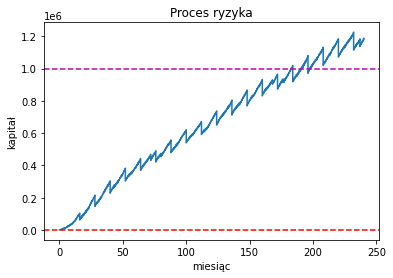

In [65]:
draw_plot(1, 240, k0, n, m, c_AC, c_OC)

##### Wnioski:
Nasza firma zarobi $10^6$ zł średnio po upływie około 16 lat.<br>
Jak jednak możemy zauważyć czas ten waha się od około 14 do 20 lat. Jest to przedział czasu, w którym prawdopodobieństwo zarobienia miliona jest bardzo wysokie.<br>
Powyższy wykres przedstawia proces ryzyka dla 20 lat, pozioma górna linia zaznacza $10^6$. Punkt przecięcia wykresu z tą linią wyznacza czas, w którym nasza firma zarobiła milion.

### Prawdopodobieństwo ruiny w ciągu 5 lat.

Będziemy badać prawdopodobieństwo ruiny w ciągu 5 lat, w zależności od:

  1.$k_0$ - kapitału początkowego,

  2.$n$ - liczby sprzedanych polis OC,

  3.$m$ - liczby sprzedanych polis AC.

#### Prawdopodobieństwo ruiny w zależności od ilości klientów OC i AC.
Sprawdzamy dla stałego kapitału początkowego ($k_0 = 1000$ zł).

In [72]:
def ruin_prob_simulation(k0, list_nm, c_OC, c_AC, start=1, stop=60):
    """Count bankruptcy probability value depend on OC and AC initial number of clients.

    Args:
        k0 [float, int]: start-up capital,
        list_nm [list]: list with OC and AC initial number of clients,
        start (int, optional): month when simulation starts. Defaults to 1.
        stop (int, optional): month when simulation stops. Defaults to 60.

    Returns:
        [list]: list with bankruptcy values.
    """
    bankruptcy_tab = []
    for value in list_nm:
        bankruptcy = 0
        for __ in range(1000):        
            time, capital, millionaire  = risk_process(start, stop+1, k0, value, value, c_AC, c_OC)
            if time[-1] != stop+1:
                bankruptcy += 1
        bankruptcy_tab.append(bankruptcy/10)
    return bankruptcy_tab

In [67]:
def draw_prob_depend_on_clients_plot(list_mn, prob_tab):
    """Draw 3d probability depend on OC and AC initial number of clients plot.

    Args:
        list_nm [list]: list with OC and AC initial number of clients,
        prob_tab [list]: list with probability of bankruptcy values.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    fig.set_size_inches(9, 7)
    ax.scatter(list_mn, list_mn, prob_tab, s=30, color="red")
    ax.set_title("Prawdopodobieństwo bankructwa w zależności od początkowej ilości klientów")
    ax.set_xlabel("m")
    ax.set_ylabel("n")
    ax.set_zlabel("prawdopodobieństwo")
    plt.show()

In [73]:
list_mn = [i*10 for i in range(1, 32, 2)]
k0 = 1000

In [ ]:
prob_tab = ruin_prob_simulation(k0, list_mn, c_OC, c_AC, start=1, stop=60)

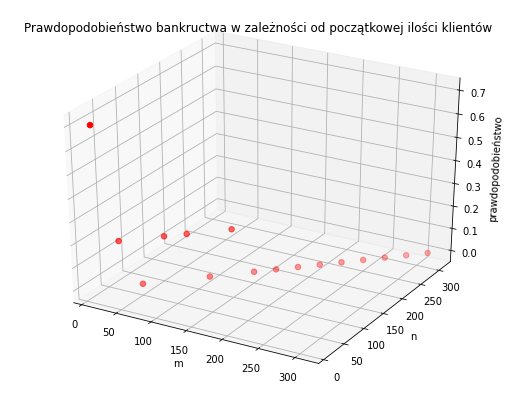

In [77]:
draw_prob_depend_on_clients_plot(list_mn, prob_tab)

##### Wnioski:
Wykres przedstawia zależność pomiędzy początkowa ilością klientów kupujących polisy OC i AC (osie poziome), a prawdopodobieństwem bankructwa (oś pionowa).<br>
Jak możemy wywnioskować, im większa liczba początkowych klientów, tym mniejsze jest prawdopodobieństwo bankructwa.<br>
Z wykresu wynika, że dla początkowej ilości klientów od około 150 wzwyż, prawdopodobieństwo ruiny wynosi 0. Z taką początkową liczbą klientów nasza firma nie zbankrutuje w ciągu 5 lat.

#### Prawdopodobieństwo ruiny w zależności od kapitału początkowego.
Sprawdzamy dla stałej ilości początkowych klientów $n = 100$, $m = 100$.

In [85]:
def ruin_prob_simulation2(k0_list, m, n, c_OC, c_AC, start=1, stop=60):
    """Count bankruptcy probability value depend on start-up capital value.

    Args:
        k0_list [list]: list of start-up capitals,
        m [int]: inital number of AC clients,
        n [int]: inital number of OC clients,
        c_OC [float, int]: OC price,
        c_AC [float, int]: AC price,
        start (int, optional): month when simulation starts. Defaults to 1.
        stop (int, optional): month when simulation stops. Defaults to 60.

    Returns:
        [list]: list with probability of bankruptcy values..
    """
    bankruptcy_tab = []
    for k in k0_list:
        bankruptcy = 0
        for __ in range(1000):       
            time, capital, millionaire  = risk_process(start, stop+1, k, m, n, c_AC, c_OC)
            if time[-1] != stop+1:
                bankruptcy += 1
        bankruptcy_tab.append(bankruptcy/10)
    return bankruptcy_tab

In [93]:
def draw_prob_depend_on_capital_plot(k0_list, prob_tab):
    """Draw 2d probability depend on start-up capital values plot.
    
    Args:
        k0_list [list]: list with start-up capitals,
        prob_tab [list]: list with probability of bankruptcy values.
    """
    plt.figure(figsize=(9, 5))
    plt.scatter(k0_list, prob_tab, color="m")
    plt.title("Prawdopodobieństwo bankructwa w zależności od kapitału początkowego")
    plt.xlabel("kapitał początkowy")
    plt.ylabel("prawdopodobieństwo")
    plt.show()

In [81]:
m = 100
n = 100
k0 = [100, 500, 750, 1000, 5000, 7500, 10000, 50000, 75000, 100000]

In [86]:
prob2_tab = ruin_prob_simulation2(k0, m, n, c_OC, c_AC, start=1, stop=60)

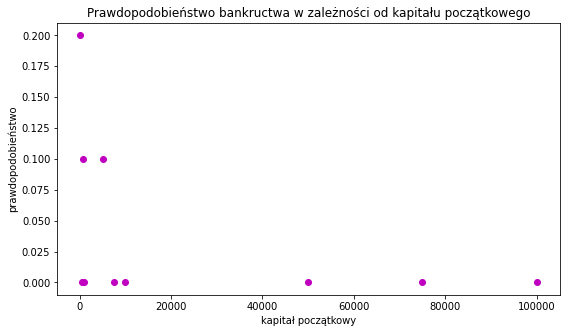

In [94]:
draw_prob_depend_on_capital_plot(k0, prob2_tab)

##### Wnioski:
Wykres przedstawia prawdopodobieństwo bankructwa w zależności od wartości kapitału początkowego. Jak widzimy od kapitału równego około 7500 zł wzwyż prawdopodobieństwo bankructwa wynosi 0. Z tego wynika, że z kapitałem początkowym równym około 7500 zł i przy początkowej liczbie klientów OC i AC równej 100 każda, nasza firma nie zbankrutuje w ciągu 5 lat.

#### Wykresy przedstwiający proces ryzyka dla 5 lat.

In [100]:
def draw_plot2(start, stop, k0, n, m, c_AC, c_OC):
    """Generate plot.

    Args:
        start [int]: month when simulation starts,
        stop [int]: month when simulation stops,
        k0 [float, int]: start-up capital,
        n [int]: initial number of OC clients,
        m [int]: initial number of AC clients,
        c_AC [float, int]: AC price,
        c_OC [float, int]: OC price.
    """
    x_range, y_range, millionaire  = risk_process(start, stop, k0, n, m, c_AC, c_OC)
    plt.plot(x_range, y_range)
    plt.axhline(y=0, linestyle="--", color="red")
    plt.title("Proces ryzyka")
    plt.xlabel("miesiąc")
    plt.ylabel("kapitał")
    plt.show()

Dla różnych wartości kapitału początkowego i stałej ilości początkowych klientów ($n=100$ i $m=100$).

Dla kapitału początkowego $k_0 = 1000$ zł.

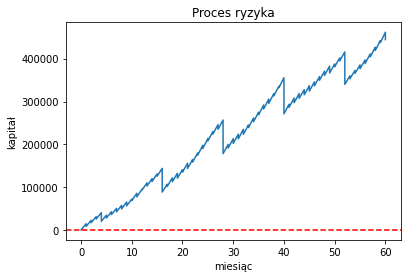

In [101]:
k0 = 1000
draw_plot2(1, 60, k0, n, m, c_AC, c_OC)

Dla kapitału początkowego $k_0 = 10 000$ zł.

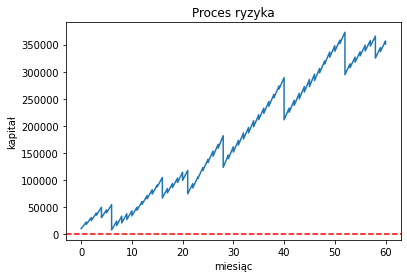

In [102]:
k0 = 10000
draw_plot2(1, 60, k0, n, m, c_AC, c_OC)

Dla kapitału początkowego $k_0 = 10 000$ zł.

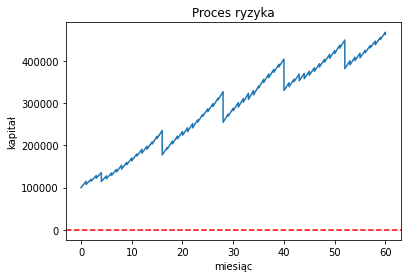

In [103]:
k0 = 100000
draw_plot2(1, 60, k0, n, m, c_AC, c_OC)

##### Wnioski:
Dla początkowego kapitału $k_0 = 1000$ zł końcowy kapitał będzie porównywalny do tego jaki osiągamy gdy $k_0 = 100 000 $ zł. Dla kapitału początkowego $k_0 = 10 000$ zł nasza firma zarobi mniej niż dla $k_0 = 1000$ zł.<br>
Z tego wynika, że początkowy kapitał nie wpływa znacząco na kapitał naszej firmy po 5 latach. 

## Animacja

Animację wykonujemy dla podanych poniżej parametrów.

In [104]:
c_OC = 80
c_AC = 60
start = 1
stop = 120
k0 = 1000
n = 10
m = 0

In [135]:
def animation_gen(start, stop, k0, n, m, c_AC, c_OC):
    """Generate risk process animation.

    Args:
        start [int]: month when simulation starts,
        stop [int]: month when simulation stops,
        k0 [float, int]: start-up capital,
        n [int]: initial number of OC clients,
        m [int]: initial number of AC clients,
        c_AC [float, int]: AC price,
        c_OC [float, int]: OC price.
    """
    fig = plt.figure(figsize=(7, 4))
    time, capital, million = risk_process(start, stop, k0, n, m, c_AC, c_OC)  

    axis = plt.axes(xlim=(0, max(time)),  ylim=(min(capital), max(capital)))
    line, = axis.plot([], [], lw=1.5)

    def animate(frame_number):
        x = time[0:frame_number]
        y = capital[0:frame_number]
        line.set_data(x, y)
        return line,


    anim = FuncAnimation(fig, animate, frames=len(time), 
                                interval=60, blit=False, repeat=False)
    fig.suptitle('Proces ryzyka', fontsize=14)
    axis.set_xlabel("miesiąc")
    axis.set_ylabel("kapitał")
    video = anim.to_html5_video()

    html = display.HTML(video)

    display.display(html)

    plt.close()

In [136]:
animation_gen(start, stop, k0, n, m, c_AC, c_OC)

## Długoletnie prognozy.

Będziemy symulować długoletni proces ryzyka dla ustalonych poniżej parametrów.

In [137]:
c_OC = 80
c_AC = 60
k0 = 1000
n = 100
m = 100

Dla czasu równego 60 lat.

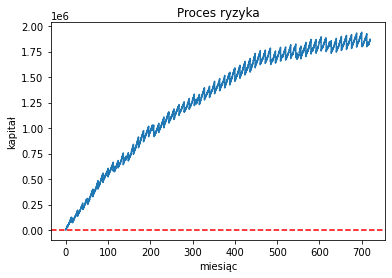

In [142]:
draw_plot2(1, 720, k0, n, m, c_AC, c_OC)

Dla czasu równego 100 lat.

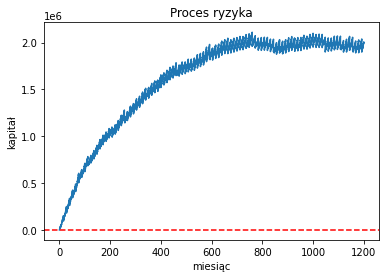

In [140]:
draw_plot2(1, 1200, k0, n, m, c_AC, c_OC)

Dla czasu równego 500 lat.

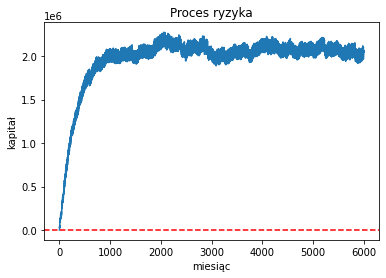

In [141]:
draw_plot2(1, 6000, k0, n, m, c_AC, c_OC)

### Wnioski:
Przeprowadzając symulację dla dłuższego okresu czasu, możemy zobaczyć, że nasz maksymalny kapitał jest ograniczony do około $2 \cdot 10^6$ zł.<br>
Po około 60 latach funkcjonowania nasza firma osiągnie ten kapitał i będzie wokół niego oscylować przez nastepne lata. Do tego czasu widzimy, że firma rozwija się w bardzo szybkim tempie.

## Źródła

  1. [wypadki drogowe w 2020](https://statystyka.policja.pl/st/ruch-drogowy/76562,wypadki-drogowe-raporty-roczne.html)